## Reproduce DARTFISH results with Pixel Decoder

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from starfish.experiment import Experiment
from starfish.codebook import Codebook
from starfish.constants import Indices
from starfish.stack import ImageStack
from starfish.image import Filter

from starfish.spots import SpotFinder

### Load image stack

In [2]:
exp = Experiment.from_json('https://dmf0bdeheu4zf.cloudfront.net/20180813/DARTFISH/fov_001/experiment.json')
stack = exp.image
# TODO the latter will be fixed by https://github.com/spacetx/starfish/issues/316
stack._data = stack._data.astype(float)

In [3]:
print(stack.numpy_array.shape)

(6, 3, 1, 988, 988)


In [4]:
stack.show_stack({Indices.CH:0}, rescale=True)

Rescaling ...


interactive(children=(IntSlider(value=0, description='plane_index', max=5), Output()), _dom_classes=('widget-i…

<function starfish.stack.ImageStack._show_matplotlib_inline.<locals>.display_slice>

### Load codebook

In [5]:
cb = Codebook.from_json('https://dmf0bdeheu4zf.cloudfront.net/20180813/DARTFISH/fov_001/codebook.json')
cb

<xarray.Codebook (target: 96, c: 3, r: 6)>
array([[[0, 1, ..., 0, 0],
        [0, 0, ..., 1, 0],
        [1, 0, ..., 0, 0]],

       [[0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 1],
        [1, 1, ..., 0, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'MYH11' 'RELN' 'NR4A2' 'COL20A1' 'IGFBP5' ...
  * c        (c) int64 0 1 2
  * r        (r) int64 0 1 2 3 4 5

### Load copy number benchmark results

In [6]:
bench = pd.read_csv('https://dmf0bdeheu4zf.cloudfront.net/20180813/DARTFISH/fov_001/counts.csv')
bench.head()

,gene,cnt
0,MYH11,29
1,RELN,22
2,NR4A2,20
3,COL20A1,14
4,IGFBP5,13


### Filter Image Stack

In [7]:
# TODO discuss with ambrose potential idiomatic starfish implementation
def zero_channels_old(stack, magnitude_thresh, normalize_by_magnitude=False):
    """
    Sets all values in a round to zero if the magnitude across color channel is below a 
    specified threshold
    """
    # r, z, y, x
    ch_magnitudes = np.linalg.norm(stack.numpy_array, ord=2, axis=1)
    magnitude_mask = ch_magnitudes >= magnitude_thresh

    magnitude_mask_repeat = np.expand_dims(magnitude_mask, axis=1)
    magnitude_mask_repeat = magnitude_mask_repeat.repeat(stack.num_chs, axis=1)
    
    ch_magnitudes_repeat = np.expand_dims(ch_magnitudes, axis=1)
    ch_magnitudes_repeat = ch_magnitudes_repeat.repeat(stack.num_chs, axis=1)
    
    res = stack.numpy_array * magnitude_mask_repeat
    
    if normalize_by_magnitude:
        res = np.divide(stack.numpy_array, ch_magnitudes_repeat, where=magnitude_mask_repeat)
    
    return ImageStack.from_numpy_array(res), ch_magnitudes

In [11]:
def zero_channels(stack, magnitude_thresh, normalize_by_magnitude=False):

    channels_per_round = stack._data.groupby(Indices.ROUND.value)
    ch_masks = dict()

    # compute mask
    for r, dat in channels_per_round:
        ch_magnitude = np.linalg.norm(dat, ord=2, axis=0)
        magnitude_mask = ch_magnitude >= magnitude_thresh
        ch_masks[r] = magnitude_mask

    new_stack = deepcopy(stack)
    # apply mask
    for r in range(stack.num_rounds):
        for c in range(stack.num_chs):
            ind = {Indices.ROUND:r, Indices.CH:c}
            new_stack._data[ind] = stack._data[ind]*ch_masks[r]
    
    return new_stack

### Apply Filters

In [12]:
from copy import deepcopy

norm_perc = 100
ch_thresh = .05
normalize_by_magnitude=False

sc = Filter.ScaleByPercentile(p=100)
norm_stack = sc.run(stack, in_place=False)
zero_norm_stack = zero_channels(norm_stack, ch_thresh, normalize_by_magnitude=normalize_by_magnitude)
zero_norm_stack.show_stack({Indices.ROUND:0})

interactive(children=(IntSlider(value=0, description='plane_index', max=2), Output()), _dom_classes=('widget-i…

<function starfish.stack.ImageStack._show_matplotlib_inline.<locals>.display_slice>

### Decode

In [13]:
magnitude_threshold = .5
area_threshold = (5, 30)
distance_threshold = 3

psd = SpotFinder.PixelSpotDetector(
    codebook=cb,
    metric='euclidean',
    distance_threshold=distance_threshold,
    magnitude_threshold=magnitude_threshold,
    min_area=area_threshold[0],
    max_area=area_threshold[1]
)

spot_intensities, results = psd.find(zero_norm_stack)
spots_df = spot_intensities.to_dataframe()
spots_df['area'] = np.pi*spots_df['radius']**2
spots_df.head()


,radius,target,x,y,z,distance,area
0,1.871205,EXPH5,955,0,0,0.648725,11.0
1,1.954410,RNF152,928,3,0,0.458121,12.0
2,1.954410,PLD4,295,5,0,0.540604,12.0
3,1.871205,CTSS,225,7,0,0.722373,11.0
4,2.185097,PCP4,383,7,0,0.523660,15.0


### QC Plots

#### parameter tuning plots

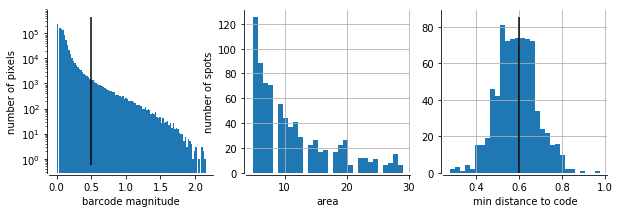

In [14]:
from starfish.intensity_table import IntensityTable

min_thresh = 0.6

def compute_magnitudes(stack, norm_order=2):
    
    pixel_intensities = IntensityTable.from_image_stack(zero_norm_stack)
    feature_traces = pixel_intensities.stack(traces=(Indices.CH.value, Indices.ROUND.value))
    norm = np.linalg.norm(feature_traces.values, ord=norm_order, axis=1)

    return norm
    
norm = compute_magnitudes(zero_norm_stack)

plt.figure(figsize=(10,3))

plt.subplot(131)
plt.hist(norm, bins=100);
plt.yscale('log')
plt.xlabel('barcode magnitude')
plt.ylabel('number of pixels')
sns.despine(offset=2)
plt.vlines(magnitude_threshold, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1])

plt.subplot(132)
spots_df['area'] = np.pi*spots_df.radius**2
spots_df.area.hist(bins=30);
plt.xlabel('area')
plt.ylabel('number of spots')
sns.despine(offset=2)

plt.subplot(133)
spots_df.distance.hist(bins=30)
plt.xlabel('min distance to code');
plt.vlines(min_thresh, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1])
sns.despine(offset=2)

#### Copy number comparisons

In [15]:
cnts_starfish = spots_df[spots_df.distance<=min_thresh].groupby('target').count()['area']
cnts_starfish = cnts_starfish.reset_index(level=0)
cnts_starfish.rename(columns = {'target':'gene', 'area':'cnt_starfish'}, inplace=True)

mrg = pd.merge(bench, cnts_starfish, on='gene', how='left')
mrg.head(20)

,gene,cnt,cnt_starfish
0,MYH11,29,32.0
1,RELN,22,12.0
2,NR4A2,20,34.0
3,COL20A1,14,15.0
4,IGFBP5,13,8.0
5,JAG1,12,27.0
6,ADCY8,12,11.0
7,ANKRD13A,10,22.0
8,INPP5D,9,6.0
9,MBP,8,20.0


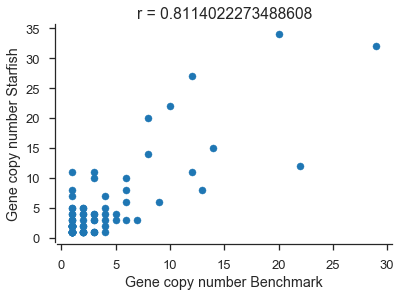

In [16]:
sns.set_context('talk')
sns.set_style('ticks')

x = mrg.dropna().cnt.values
y = mrg.dropna().cnt_starfish.values
r = np.corrcoef(x, y)
r = r[0,1]

plt.scatter(x, y, 50,zorder=2)

plt.xlabel('Gene copy number Benchmark')
plt.ylabel('Gene copy number Starfish')
plt.title('r = {}'.format(r))

sns.despine(offset=2)

#### visualization of rolonies

In [17]:
distance_threshold = min_thresh

psd = SpotFinder.PixelSpotDetector(
    codebook=cb,
    metric='euclidean',
    distance_threshold=distance_threshold,
    magnitude_threshold=magnitude_threshold,
    min_area=area_threshold[0],
    max_area=area_threshold[1]
)

spot_intensities, results = psd.find(zero_norm_stack)

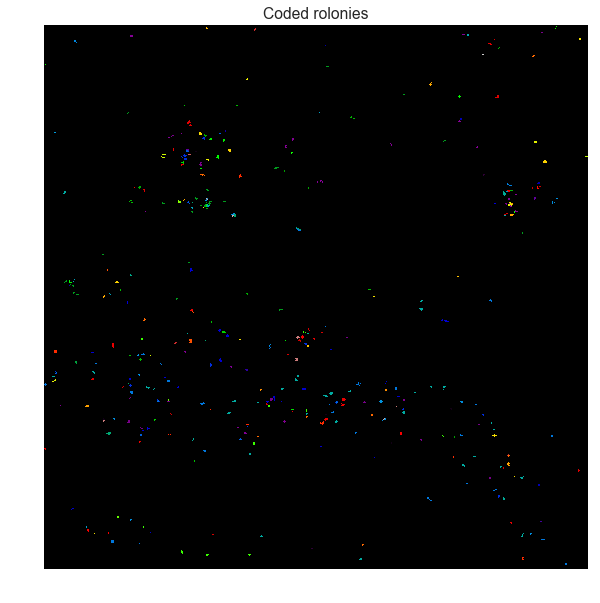

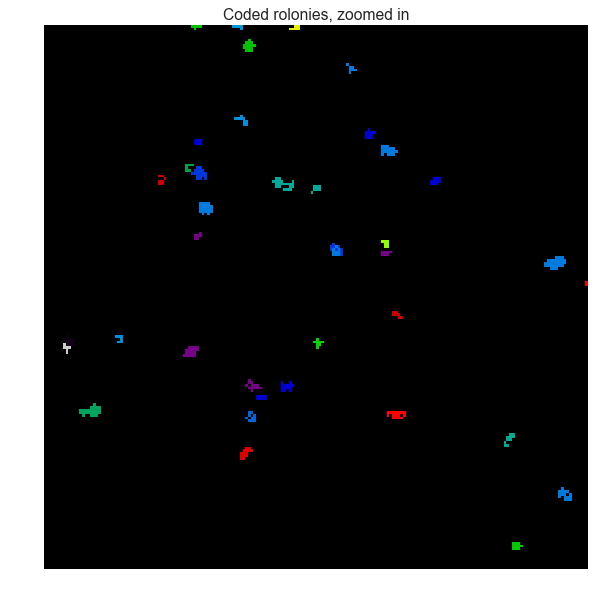

In [18]:
area_lookup = lambda x: 0 if x == 0 else results.region_properties[x - 1].area
vfunc = np.vectorize(area_lookup)
mask = np.squeeze(vfunc(results.label_image))
new_image = np.squeeze(results.decoded_image)*(mask > area_threshold[0])*(mask < area_threshold[1])

plt.figure(figsize=(10,10))
plt.imshow(new_image, cmap = 'nipy_spectral');
plt.axis('off');
plt.title('Coded rolonies');

plt.figure(figsize=(10,10))
plt.imshow(new_image[600:800, 100:300], cmap = 'nipy_spectral');
plt.axis('off');
plt.title('Coded rolonies, zoomed in');

### visualization of matched barcodes

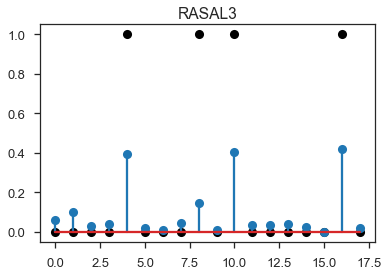

In [19]:
pbcs = spot_intensities
pbcs = pbcs.stack(traces=(Indices.ROUND.value, Indices.CH.value))
pbcs_df = pbcs.features.to_index().to_frame(index=False)
pbcs_df['area'] = np.pi*pbcs_df.radius**2

n = int(np.ceil(np.random.rand()*len(pbcs_df)))-1
gn = pbcs_df.loc[n].target
thi_bc = cb[cb.target==gn].stack(traces=(Indices.ROUND.value, Indices.CH.value)).values[0]
plt.plot(thi_bc, 'ok')
plt.stem(pbcs[n,:])
plt.title(gn);